In [57]:
%run _utils.ipynb

PROJECT_ROOT = '..'
PLOTS_PATH = f'{PROJECT_ROOT}/plots'
CSV_FOLDER = 'csv'
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

issues = load_issues()
comments = load_comments()

/Users/BenRombaut/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (14,16,17,20) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [58]:
len(comments)

365625

# Comments on Breaking Issues

# How many comments do Greenkeeper Breaking Issues have?

In [59]:
bot_comments = comments[(comments['comment_user_type'] == "Bot")]

print(f'# of bot comments: {len(bot_comments)}')
greenkeeper_comments = bot_comments[bot_comments['comment_user_login'].str.contains('greenkeeper')]
print(f'# of greenkeeper comments: {len(greenkeeper_comments)}')


# of bot comments: 354901
# of greenkeeper comments: 354250


# User Comments

In [60]:
users_comments = comments[(comments['comment_user_type'] == "User")].copy()
percent_of_user_comments = calculate_percent(len(users_comments), len(comments))
unique_issue_ids = users_comments['comment_issue_id'].unique()
percent_of_issues_with_user_comment = calculate_percent(len(unique_issue_ids), len(issues['issue_id']))
s = f'''
{len(users_comments)} comments from users ({percent_of_user_comments}% of comments) on \
{len(unique_issue_ids)} unique issues ({percent_of_issues_with_user_comment}% of issues)
'''
print(s)


10724 comments from users (2.93% of comments) on 9854 unique issues (8.0% of issues)



# What are users saying?

In [61]:
NOT_CLASSIFIED = 'Other'

# Set all comments to 'Not Classified'
users_comments['comment_classification'] = NOT_CLASSIFIED
users_comments = users_comments.drop(users_comments[pd.isna(users_comments['comment_body'])].index)

In [62]:
################################
# START FIX_REFERENCED
################################
FIX_REFERENCED = 'Fix Referenced'

reg_pr_url = 'https:\/\/github\.com\/[\S]*\/(pull|issues)\/[\S]*'
reg_closed_by = '(closed|fixed|resolved|done|updated) (in|by|via|with)'
reg_number = '^#\d*|(Merged|Close|PR|see).*#\d*'

users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['comment_body'].str.contains(pat=reg_pr_url, case=True, regex=True)) |
        (users_comments['comment_body'].str.contains(pat=reg_closed_by, case=False, regex=True)) |
        (users_comments['comment_body'].str.contains(pat=reg_number, case=False, regex=True))
    ),
    'comment_classification'
] = FIX_REFERENCED

fix_referenced_comments = users_comments[users_comments['comment_classification'] == FIX_REFERENCED]
print(f"{len(fix_referenced_comments)} comments from users explicitly link a fix.")
# fix_referenced_comments['comment_body'].sample(10)
################################
# END FIX_REFERENCED
################################


################################
# START FALSE_ALARM
################################
FALSE_ALARM = 'False Alarm'

reg_flaky = 'flake|flaky|flakiness|fluke|(server|test) hiccup|inconsistent test|brittle test|unstable unit test|unstable test|Spurious test failure|Tests are passing'
reg_random = '(fail|failing) random|random.*fail.*|random build error|intermittent'
reg_retrigger = '(retrigger|re-trigger|rebuild|re-build|restart|re-starting|re-run|retried|rerun|reran|re-ran)'
reg_false_positive = 'false (positive|alarm|negative|alert)|falso positive'
reg_invalid = '^(invalid|not applicable|not (a|an) issue|unrelated)|Couldn\'t reproduce|all tests pass'
reg_unrelated='(unrelated.*fail)|(failed for other reasons)|(build is actually passing)|build hiccup'
reg_timeout = 'timeout|time-out'


users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['comment_body'].str.contains(pat=reg_flaky, case=False, regex=True)) |
        (users_comments['comment_body'].str.contains(pat=reg_random, case=False, regex=True)) |
        (users_comments['comment_body'].str.contains(pat=reg_retrigger, case=False, regex=True)) |
        (users_comments['comment_body'].str.contains(pat=reg_false_positive, case=False, regex=True)) | 
        (users_comments['comment_body'].str.contains(pat=reg_invalid, case=False, regex=True)) |
        (users_comments['comment_body'].str.contains(pat=reg_unrelated, case=False, regex=True)) |
        (users_comments['comment_body'].str.contains(pat=reg_timeout, case=False, regex=True))
    ),
    'comment_classification'
] = FALSE_ALARM


false_alarm_comments = users_comments[users_comments['comment_classification'] == FALSE_ALARM]
print(f"{len(false_alarm_comments)} comments from users indicate a false alarm.")
# false_alarm_comments['comment_body'].sample(10)
################################
# END FALSE_ALARM
################################



################################
# START TRANSIENT_FAILURE
################################
TRANSIENT_FAILURE = 'Transient Failure'

reg_transient = 'transient.*fail'

users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['comment_body'].str.contains(pat=reg_transient, case=False, regex=True))
    ),
    'comment_classification'
] = TRANSIENT_FAILURE

transient_failure_comments = users_comments[users_comments['comment_classification'] == TRANSIENT_FAILURE]
print(f"{len(transient_failure_comments)} comments saying failure was caused by transient dependency")
# transient_failure_comments['comment_body'].sample(10)
################################
# END TRANSIENT_FAILURE
################################



################################
# START MENTION_GREENKEEPER
################################
MENTION_GREENKEEPER = 'Mention Greenkeeper'

reg_greenkeeper = '(greenkeeper)'

users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['comment_body'].str.contains(pat=reg_greenkeeper, case=False, regex=True))
    ),
    'comment_classification'
] = MENTION_GREENKEEPER

mention_greenkeeper_comments = users_comments[users_comments['comment_classification'] == MENTION_GREENKEEPER]
print(f"{len(mention_greenkeeper_comments)} comments mentioning Greenkeeper")
# mention_greenkeeper_comments['comment_body'].sample(10)
################################
# END MENTION_GREENKEEPER
################################

################################
# START MENTION_CI_SYSTEM
################################
MENTION_CI_SYSTEM = 'Mention CI System'

reg_ci_system = '(travis|CircleCI|circle ci|jarvis|jenkins|CI.*issue)'

users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['comment_body'].str.contains(pat=reg_ci_system, case=False, regex=True))
    ),
    'comment_classification'
] = MENTION_CI_SYSTEM

mention_ci_system_comments = users_comments[users_comments['comment_classification'] == MENTION_CI_SYSTEM]
print(f"{len(mention_ci_system_comments)} comments the projects CI build system")
# mention_greenkeeper_comments['comment_body'].sample(10)
################################
# END MENTION_CI_SYSTEM
################################


################################
# START FIX_MENTIONED
################################
FIX_MENTIONED = 'Fix Mentioned'

reg_fixed = '(fix(ed)*|resolved|done|solved|closed|updated|upgraded|closing|merged)|(fix|fixed|bumped|merged|upgraded).*manually|manually.*merged'
reg_update_in = '.*update.*in.*|Making a PR'

users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['comment_body'].str.contains(pat=reg_fixed, case=False, regex=True)) | 
        (users_comments['comment_body'].str.contains(pat=reg_update_in, case=False, regex=True))
    ),
    'comment_classification'
] = FIX_MENTIONED

fix_mentioned_comments = users_comments[users_comments['comment_classification'] == FIX_MENTIONED]
print(f"{len(fix_mentioned_comments)} comments from users saying the issues has been fixed (without linking the fix).")
# fix_mentioned_comments['comment_body'].sample(10)
################################
# END FIX_MENTIONED
################################

3704 comments from users explicitly link a fix.
1959 comments from users indicate a false alarm.
26 comments saying failure was caused by transient dependency
386 comments mentioning Greenkeeper
490 comments the projects CI build system
1865 comments from users saying the issues has been fixed (without linking the fix).


In [63]:
users_comments['comment_classification'].unique()

array(['Fix Referenced', 'Fix Mentioned', 'Mention Greenkeeper',
       'False Alarm', 'Other', 'Mention CI System', 'Transient Failure'],
      dtype=object)

In [102]:
users_comments[users_comments['comment_classification'] == 'Transient Failure'][['comment_body']].sample(3)

,comment_body
355644,There was a transient build failure at this time.
313211,"transient travis failure (nvm installing node 6, not always node 8)."
33184,Transient BrowserStack failure...


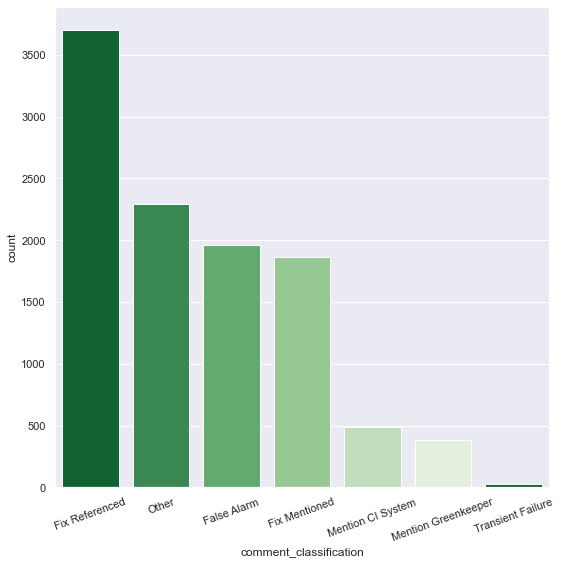

In [33]:
sns.set()

fig, ax = plt.subplots(figsize=(8, 8))

users_comments['comment_classification'].unique()

cp = sns.countplot(
    data=users_comments,
    x="comment_classification",
    order = users_comments['comment_classification'].value_counts().index,
    palette=COLOUR_PALETTE,
)

# gist_earth
# Paired
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
fig.tight_layout()
save_plot(cp.get_figure(), 'types_of_user_comments.png')

# How Quickly Do Users Comment

In [34]:
first_user_comments = \
    users_comments.loc[users_comments.groupby(['comment_issue_id'])["comment_created_at"].idxmin()]
rel_time_comment_to_issue = pd.DataFrame({
    'comment_id': first_user_comments['comment_id'],
    'comment_created_at': first_user_comments['comment_created_at'],
    'issue_id': first_user_comments['comment_issue_id'],
})
# rel_time_comment_to_issue['comment_created_at']
rel_time_comment_to_issue.reset_index()

def get_comment_created_at(row, issues):
    issue = issues[issues['issue_id'] == row.issue_id]
    if issue.empty:
        return pd.NA
    return issue['issue_created_at'].iloc[0]
    
    
rel_time_comment_to_issue['issue_created_at'] = \
    rel_time_comment_to_issue.progress_apply(lambda row: get_comment_created_at(row, issues), axis=1)
rel_time_comment_to_issue = rel_time_comment_to_issue.dropna()
rel_time_comment_to_issue['issue_created_at'] = pd.to_datetime(rel_time_comment_to_issue['issue_created_at'], utc=True)

def get_time_diff(row):
    return row['comment_created_at'] - row['issue_created_at']

rel_time_comment_to_issue['time_diff'] = rel_time_comment_to_issue.progress_apply(get_time_diff, axis=1)


print(f'5 number summary of time until first user comment:')
print(rel_time_comment_to_issue['time_diff'].describe())

  0%|          | 0/9853 [00:00<?, ?it/s]

  0%|          | 0/9830 [00:00<?, ?it/s]

5 number summary of time until first user comment:
count                          9830
mean     26 days 06:01:46.397761953
std      65 days 16:10:10.331253024
min                 0 days 00:00:00
25%          0 days 07:45:44.500000
50%                 2 days 12:22:44
75%         18 days 22:36:09.750000
max              1039 days 05:34:55
Name: time_diff, dtype: object


In [35]:
def get_comment_type(row):
    if row['comment_id'] in fix_referenced_comments['comment_id'].unique():
        return FIX_REFERENCED
    if row['comment_id'] in false_alarm_comments['comment_id'].unique():
        return FALSE_ALARM
    if row['comment_id'] in transient_failure_comments['comment_id'].unique():
        return TRANSIENT_FAILURE
    if row['comment_id'] in mention_greenkeeper_comments['comment_id'].unique():
        return MENTION_GREENKEEPER
    if row['comment_id'] in mention_ci_system_comments['comment_id'].unique():
        return MENTION_CI_SYSTEM
    if row['comment_id'] in fix_mentioned_comments['comment_id'].unique():
        return FIX_MENTIONED
    return NOT_CLASSIFIED

rel_time_comment_to_issue['comment_classification'] = \
    rel_time_comment_to_issue.progress_apply(get_comment_type, axis=1)
rel_time_comment_to_issue['x_seconds'] = \
    rel_time_comment_to_issue['time_diff'].astype('timedelta64[s]')

rel_time_comment_to_issue.drop(
    rel_time_comment_to_issue[ rel_time_comment_to_issue['x_seconds'] == 0 ].index , inplace=True)

rel_time_comment_to_issue['x_seconds_log'] = \
    np.log10(rel_time_comment_to_issue['x_seconds'])
rel_time_comment_to_issue['x_days'] = \
    rel_time_comment_to_issue['x_seconds'] / 86400

  0%|          | 0/9830 [00:00<?, ?it/s]

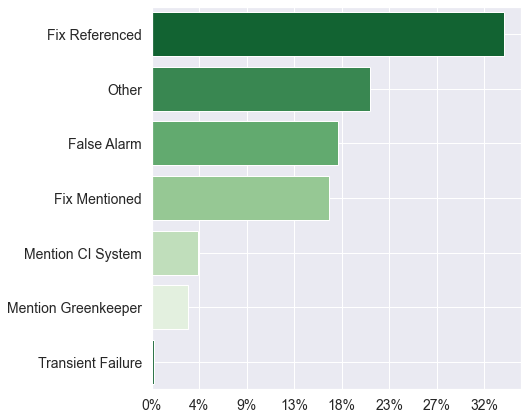

In [36]:
sns.set()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(FIG_SIZE_W, FIF_SIZE_H))

params = dict(
    data=users_comments,
    y="comment_classification",
    order = users_comments['comment_classification'].value_counts().index,
)
ax = sns.countplot(
    **params,
    palette=COLOUR_PALETTE,
    ax=ax,
)
ax.set_title(f'')
type_labels = [f'{int((y/len(users_comments)*100))}%' for y in ax.get_xticks()]
ax.set_xticklabels(type_labels, fontsize=PLOT_TICK_LABEL_SIZE, rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=PLOT_TICK_LABEL_SIZE)
ax.set_ylabel('', fontsize=PLOT_LABEL_SIZE)
ax.set_xlabel('', fontsize=20)
ax.grid(b=True, which='major', color='w', linewidth=1.0)
fig.tight_layout()
plt.show()
save_plot(fig, f'{PLOTS_PATH}/user_comment_type.png')

In [37]:
rel_time_comment_to_issue['x_seconds'].describe()
PLOT_LABEL_SIZE = 16
PLOT_TICK_LABEL_SIZE = 14

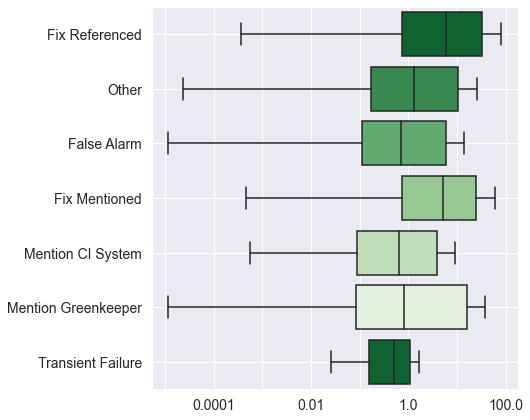

In [38]:
sns.set()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(FIG_SIZE_W, FIF_SIZE_H))

params = dict(
    data=rel_time_comment_to_issue,
    x='x_days',
    y='comment_classification',
    order = users_comments['comment_classification'].value_counts().index,
)
ax = sns.boxplot(
    **params,
    showfliers=False,
    palette=COLOUR_PALETTE,
)
ax.set_xscale('log')
# ax.set_xticklabels(x_ticks, fontsize=14, rotation=0)

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 2 == 1:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.set_xticklabels(ax.get_xticks(), rotation=0, fontsize=PLOT_TICK_LABEL_SIZE)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=PLOT_TICK_LABEL_SIZE)
# ax.set_yticklabels([])
ax.set_title(f'')
ax.set_ylabel(f'', fontsize=PLOT_LABEL_SIZE)
ax.set_xlabel(f'', fontsize=PLOT_LABEL_SIZE)
# ax.set_xlabel(f'Time Until First User Comment in Days (Log Scale)', fontsize=PLOT_LABEL_SIZE)
ax.grid(b=True, which='major', color='w', linewidth=1.0)

fig.tight_layout()
plt.show()
save_plot(fig, f'{PLOTS_PATH}/time_until_user_comment.png')